In [0]:
!pip install torch==2.0.1 torchvision==0.15.2 diffusers==0.19.3 transformers==4.30.1 accelerate==0.21.0 huggingface_hub==0.16.4 xformers==0.0.20

Python interpreter will be restarted.
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1+cu117
    Not uninstalling torch at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-b1603c38-b1fc-44e0-bed7-afafe1d0b120
    Can't uninstall 'torch'. No files were found to uninstall.
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.12.0
    Not uninstalling huggingface-hub at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-b1603c38-b1fc-44e0-bed7-afafe1d0b120
    Can't uninstall 'huggingface-hub'. No files were found to uninstall.
  Attempting uninstall: transformers
    Found existing installation: transformers 4.25.1
    Not uninstalling transformers at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-b1603c38-b1fc-44e0-bed7-afafe1d0b120
    

In [0]:
import os
import requests
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np
import random
from diffusers import StableDiffusionPipeline
from diffusers import StableDiffusionImg2ImgPipeline
from torch.utils.data import Subset
from diffusers import StableDiffusionInpaintPipeline
from PIL import Image, ImageChops
from pathlib import Path


# Автоматический выбор устройства (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используется устройство: {device}")

Используется устройство: cuda


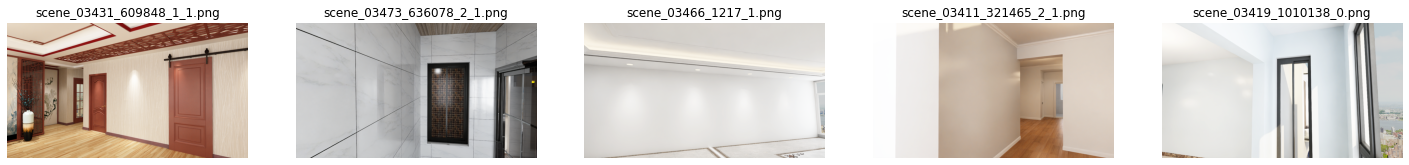

In [0]:
# Путь к папке с изображениями
folder_path = Path("/Workspace/empty_images")

# Получаем список всех файлов с расширениями .jpg, .png и т.д.
image_files = list(folder_path.glob("*.jpg")) + list(folder_path.glob("*.png"))

# Выбираем 5 случайных изображений
sample_files = random.sample(image_files, 5)

# Загружаем изображения
images = [Image.open(img_path).convert("RGB") for img_path in sample_files]

# Отображаем
def display_images(images, titles=None):
    plt.figure(figsize=(5 * len(images), 5))
    for i, img in enumerate(images):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(img)
        plt.axis("off")
        if titles:
            plt.title(titles[i])
    plt.show()

# Отображаем 5 изображений
display_images(images, [f.name for f in sample_files])


In [0]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels=out_channels * 2, out_channels=out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # Выравнивание размеров
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class ResNetUNet(nn.Module):
    def __init__(self, n_classes=3):
        super().__init__()
        base_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

        self.in_conv = nn.Sequential(
            base_model.conv1,
            base_model.bn1,
            base_model.relu
        )

        self.maxpool = base_model.maxpool
        self.encoder1 = base_model.layer1  # 64
        self.encoder2 = base_model.layer2  # 128
        self.encoder3 = base_model.layer3  # 256
        self.encoder4 = base_model.layer4  # 512

        # decoder
        self.up1 = Up(512, 256)
        self.up2 = Up(256, 128)
        self.up3 = Up(128, 64)
        self.up4 = Up(64, 64)

        # Финальный апсемплинг
        self.final_upsample = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, n_classes, kernel_size=1)
        )

    def forward(self, x):
        input_size = x.size()[2:]

        # encoder 
        x0 = self.in_conv(x)       
        x1 = self.maxpool(x0)       
        x2 = self.encoder1(x1)      
        x3 = self.encoder2(x2)      
        x4 = self.encoder3(x3)      
        x5 = self.encoder4(x4)      

        # decoder
        x = self.up1(x5, x4)        
        x = self.up2(x, x3)         
        x = self.up3(x, x2)         
        x = self.up4(x, x0)         

        x = self.final_upsample(x)  
        x = torch.sigmoid(x)
        x = F.interpolate(x, size=input_size, mode='bilinear', align_corners=False)
        return x



In [0]:
class HybridFurnitureModelInpaint(nn.Module):
    def __init__(self, resnet_unet, device='cuda'):
        super(HybridFurnitureModelInpaint, self).__init__()
        self.resnet_unet = resnet_unet.to(device)
        self.device = device

        self.sd_pipe = StableDiffusionInpaintPipeline.from_pretrained(
            "/tmp/sd21_offline",
            torch_dtype=torch.float16,
            safety_checker=None
        ).to(device)
        self.sd_pipe.enable_attention_slicing()

        self.resize_transform = transforms.Compose([
            transforms.Resize((256, 256), interpolation=Image.LANCZOS),
        ])

    def forward(self, x, prompt="modern furniture in realistic interior", 
                mask_threshold=0.3, strength=0.8, guidance_scale=8.0, steps=50):
        self.eval()
        results = []

        for i in range(x.size(0)):
            input_tensor = x[i].to(self.device).unsqueeze(0)

            with torch.no_grad():
                pred_mask = self.resnet_unet(input_tensor)
            mask = (pred_mask[0, 0] > mask_threshold).float()

            if mask.mean() < 0.05:
                results.append(input_tensor)
                continue

            input_img = transforms.ToPILImage()(input_tensor.squeeze(0).cpu().clamp(0, 1))
            mask_img = transforms.ToPILImage()(mask.cpu())

            input_img = self.resize_transform(input_img)
            mask_img = self.resize_transform(mask_img)

            result = self.sd_pipe(
                prompt=prompt,
                image=input_img,
                mask_image=mask_img,
                strength=strength,
                guidance_scale=guidance_scale,
                num_inference_steps=steps,
            ).images[0]

            result_tensor = transforms.ToTensor()(result).unsqueeze(0).to(self.device).clamp(0, 1)
            results.append(result_tensor)

        return torch.cat(results, dim=0)

    def visualize_sample(self, x, prompt="interior with modern furniture",
                        mask_threshold=0.3, strength=0.8, guidance_scale=8.0, steps=50, save_path=None):
        x = x.to(self.device)
        result_tensor = self.forward(x, prompt=prompt, mask_threshold=mask_threshold,
                                    strength=strength, guidance_scale=guidance_scale, steps=steps)

        fig, axs = plt.subplots(1, 3, figsize=(15, 5))

        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]

        img = x[0].cpu().clone()
        img = denormalize(img, mean, std)
        img = img.clamp(0, 1)
        input_img = transforms.ToPILImage()(img)
        axs[0].imshow(input_img)
        axs[0].set_title("Input of empty photo")

        with torch.no_grad():
            mask = self.resnet_unet(x[0:1])[0, 0].clamp(0, 1)
        axs[1].imshow(mask.cpu(), cmap='gray')
        axs[1].set_title("Predicted Mask")

        result_img = transforms.ToPILImage()(result_tensor[0].cpu())
        axs[2].imshow(result_img)
        axs[2].set_title("Final Result")

        for ax in axs:
            ax.axis('off')
        plt.tight_layout()
        plt.show()

    # Сохранение итогового изображения
        if save_path is not None:
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            result_img.save(save_path)
            print(f"Saved result to: {save_path}")

In [0]:
# Инициализация модели и оптимизатора

# Инициализируем и загружаем веса отдельно
resnet_unet = ResNetUNet(n_classes=1)
resnet_unet.load_state_dict(torch.load("resnetunet_mask_weights.pth"))

# Передаём готовую модель внутрь HybridFurnitureModel
model_hybrid = HybridFurnitureModelInpaint(resnet_unet=resnet_unet, device=device).to(device)
model_hybrid.eval()

The config attributes {'image_encoder': [None, None]} were passed to StableDiffusionInpaintPipeline, but are not expected and will be ignored. Please verify your model_index.json configuration file.
Keyword arguments {'image_encoder': [None, None]} are not expected by StableDiffusionInpaintPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

The config attributes {'attention_type': 'default', 'dropout': 0.0, 'reverse_transformer_layers_per_block': None} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.
The config attributes {'latents_mean': None, 'latents_std': None, 'mid_block_add_attention': True, 'shift_factor': None, 'use_post_quant_conv': True, 'use_quant_conv': True} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


Out[21]: HybridFurnitureModelInpaint(
  (resnet_unet): ResNetUNet(
    (in_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (encoder1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (

  0%|          | 0/45 [00:00<?, ?it/s]

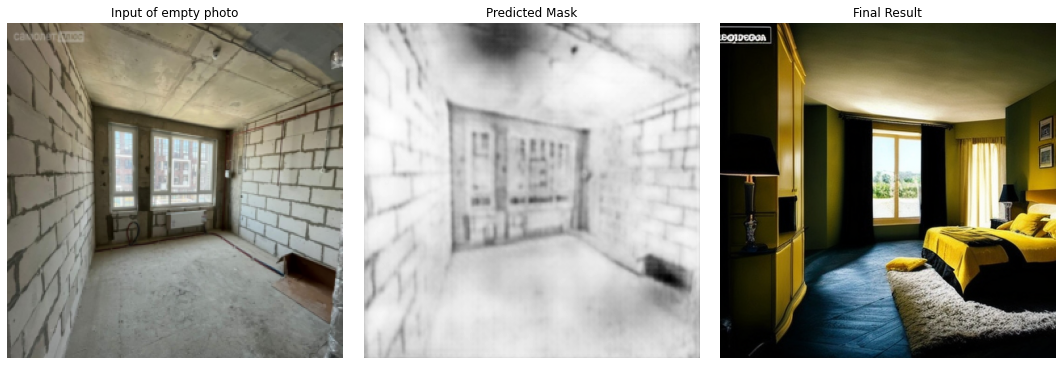

Saved result to: /Workspace/Repos/sDNA_RU/Russian_Data_Projects_dev/Nastya projects dev/educ/generated_photos/result1.png


In [0]:
# Трансформ с нормализацией
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

# Загрузка картинки и визуализация
image = Image.open("/Workspace/educ/empty_room.jpg").convert('RGB')
input_tensor = transform(image).unsqueeze(0).to(device)
output_dir = "/Workspace/educ/generated_photos/result1.png"  

model_hybrid.visualize_sample(input_tensor, 
                              prompt="classic bedroom, wooden furniture, yellow colors, painting on the wall",     
                              mask_threshold=0.3, # Чем ниже порог — тем больше область считается мебелью
                              strength=0.9, # Чем ближе к 1, тем сильнее модель изменит область, залечивая маску новыми деталями. Чем ближе к 0, тем сильнее сохраняется исходное изображение.
                              guidance_scale=8, #привязка к текстовому описанию
                              steps=50, # Качество и детализаци
                              save_path=output_dir)

